# Digit Recognition Using SVM

A classic problem in the field of pattern recognition is that of handwritten digit recognition. Suppose that you have images of handwritten digits ranging from 0-9 written by various people in boxes of a specific size - similar to the application forms in banks and universities.
 
The goal is to develop a model that can correctly identify the digit (between 0-9) written in an image. 


### Data Understanding

Let's first understand the shape, attributes etc. of the dataset.

In [1]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# dataset
digits_train = pd.read_csv("train.csv")
X_test = pd.read_csv("test.csv")

In [2]:
# about the dataset

# dimensions
print("Dimensions: ", digits_train.shape, "\n")

# data types
print(digits_train.info())

# head
digits_train.head()

Dimensions:  (42000, 785) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(digits_train.columns)

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)


In [4]:
order = list(np.sort(digits_train['label'].unique()))
print(order)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


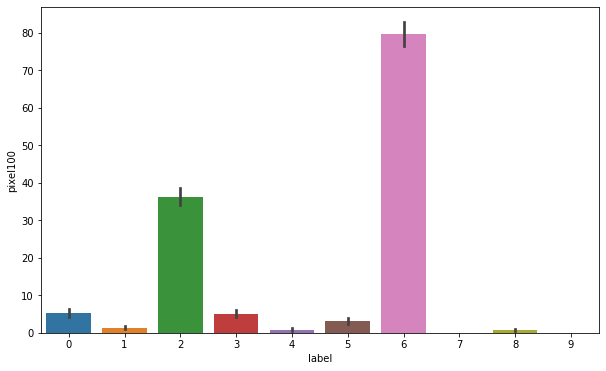

In [5]:
# basic plots: How do various attributes vary with the label

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='pixel100', 
            data=digits_train, 
            order=order)

plt.show()

In [6]:
X_train = digits_train.drop("label", axis = 1)
y_train = digits_train['label']

In [7]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

In [9]:
print(f'X_train = {X_train.shape}, y = {y_train.shape}, X_test = {X_test.shape}')

X_train = (42000, 784), y = (42000,), X_test = (28000, 784)


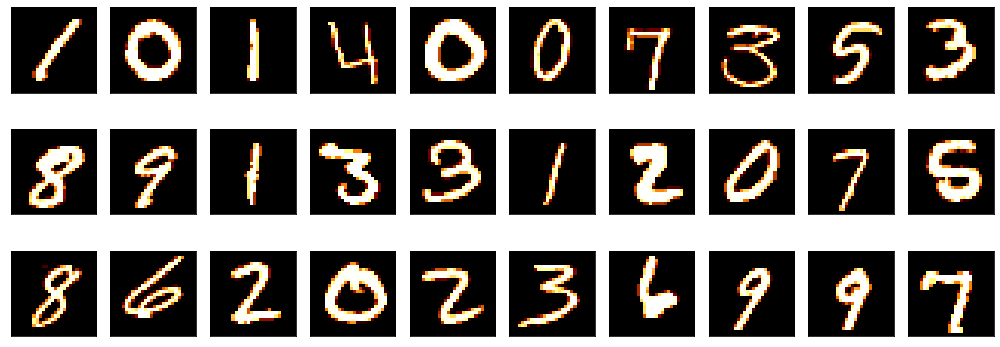

In [10]:
# Plotting some digits

plt.figure(figsize=(14,12))
for digit_num in range(0,30):
    plt.subplot(7,10,digit_num+1)
    grid_data = X_train.iloc[digit_num].values.reshape(28,28)  # reshape from 1d to 2d pixel array
    plt.imshow(grid_data, interpolation = "none", cmap = "afmhot")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [11]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
normalized_X_train = scaler.transform(X_train)
normalized_X_test = scaler.transform(X_test)

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca = PCA(random_state=42)

In [14]:
pca.fit(normalized_X_train)

PCA(random_state=42)

In [15]:
pca.components_

array([[-3.57976067e-19,  2.22044605e-16,  1.11022302e-16, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-5.15181118e-19, -5.55111512e-17, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 1.57308650e-19, -0.00000000e+00,  4.16333634e-17, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -3.48625276e-02, -7.25186740e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -1.77127304e-01,  5.91756316e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -6.03333841e-03, -1.17129353e-02, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

In [16]:
pca.explained_variance_ratio_

array([9.74849587e-02, 7.15994194e-02, 6.14562512e-02, 5.37905900e-02,
       4.89404049e-02, 4.30301914e-02, 3.27690238e-02, 2.89197264e-02,
       2.76677718e-02, 2.34876474e-02, 2.09923040e-02, 2.05890808e-02,
       1.70247659e-02, 1.69271060e-02, 1.58105493e-02, 1.48317296e-02,
       1.31962823e-02, 1.28266983e-02, 1.18792248e-02, 1.15270281e-02,
       1.07214287e-02, 1.01515377e-02, 9.64858920e-03, 9.12804956e-03,
       8.87600858e-03, 8.38728506e-03, 8.11819333e-03, 7.77370709e-03,
       7.40601855e-03, 6.86630755e-03, 6.57952735e-03, 6.38770013e-03,
       5.99340176e-03, 5.88887049e-03, 5.64309817e-03, 5.40942900e-03,
       5.09199005e-03, 4.87483066e-03, 4.75548291e-03, 4.66523779e-03,
       4.52932253e-03, 4.44969301e-03, 4.18236591e-03, 3.97487987e-03,
       3.84524817e-03, 3.74902645e-03, 3.60997053e-03, 3.48506575e-03,
       3.36472931e-03, 3.20723970e-03, 3.15453096e-03, 3.09131806e-03,
       2.93696071e-03, 2.86528720e-03, 2.80747137e-03, 2.69606405e-03,
      

In [17]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

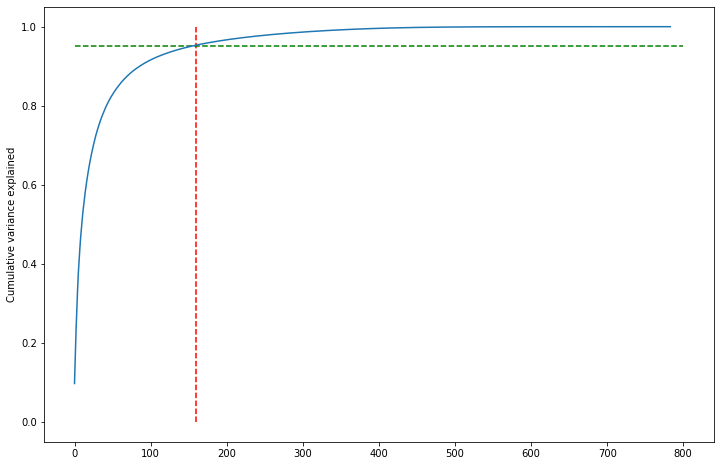

In [18]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=160, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=800, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [19]:
from sklearn.decomposition import IncrementalPCA

In [20]:
pca_final = IncrementalPCA(n_components=160)

In [21]:
train_pca = pca_final.fit_transform(normalized_X_train)

In [22]:
train_pca.shape

(42000, 160)

In [23]:
test_pca = pca_final.transform(normalized_X_test)
test_pca.shape

(28000, 160)

In [24]:
print(f'{pca.explained_variance_} \n Number of PCA Vectors = {len(pca.explained_variance_)}' )

[2.05939621e+01 1.51255717e+01 1.29827998e+01 1.13634081e+01
 1.03387933e+01 9.09024470e+00 6.92254521e+00 6.10937067e+00
 5.84489188e+00 4.96182926e+00 4.43468119e+00 4.34949919e+00
 3.59652800e+00 3.57589708e+00 3.34002144e+00 3.13324312e+00
 2.78775045e+00 2.70967483e+00 2.50951847e+00 2.43511597e+00
 2.26493090e+00 2.14453989e+00 2.03829065e+00 1.92832524e+00
 1.87508090e+00 1.77183673e+00 1.71499037e+00 1.64221672e+00
 1.56454152e+00 1.45052610e+00 1.38994301e+00 1.34941899e+00
 1.26612239e+00 1.24403987e+00 1.19211980e+00 1.14275656e+00
 1.07569672e+00 1.02982121e+00 1.00460867e+00 9.85544144e-01
 9.56831676e-01 9.40009725e-01 8.83536148e-01 8.39704159e-01
 8.12319110e-01 7.91992011e-01 7.62616071e-01 7.36229598e-01
 7.10808198e-01 6.77538091e-01 6.66403226e-01 6.53049330e-01
 6.20440920e-01 6.05299696e-01 5.93085946e-01 5.69550846e-01
 5.61550994e-01 5.41413788e-01 5.36180277e-01 5.20035151e-01
 5.06384372e-01 5.04321466e-01 4.80771848e-01 4.67943024e-01
 4.51920738e-01 4.354431

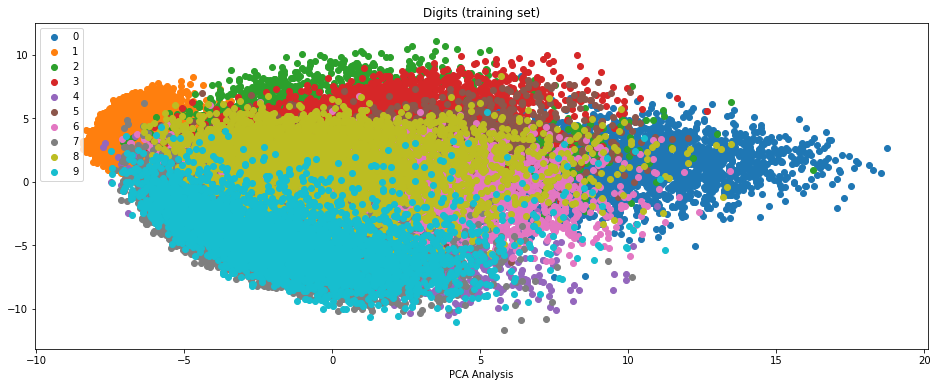

In [26]:
# Plotting PCA output
f, ax = plt.subplots(1, 1)
for i in range(10):
  ax.scatter(train_pca[y_train == i, 0], train_pca[y_train == i, 1], label=i)
ax.set_xlabel("PCA Analysis")
ax.legend()
f.set_size_inches(16, 6)
ax.set_title("Digits (training set)")
plt.show()

### Model Building

In [31]:
## creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [0.0001, 0.001, 0.01, 0.1],
                     'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


# specify modelb
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(train_pca[:10000], y_train[:10000])  

print("The best parameters are %s with a score of %0.2f"
       % (model_cv.best_params_, model_cv.best_score_))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 129.6min finished


The best parameters are {'C': 10, 'gamma': 0.01} with a score of 0.97


In [34]:
# model with optimal hyperparameters

# model
model = SVC(C=10, gamma=0.01, kernel="rbf")

model.fit(train_pca, y_train)

# metrics
train_score = model.score(train_pca, y_train)

y_pred = model.predict(test_pca)

In [36]:
print(train_score)

1.0


In [38]:
# Saving predictions to a .csv file
# the testing accuracy (in terms of how many correct classifications)

ImageId = [i+1 for i in range(len(y_pred))]
kaggle = pd.DataFrame({'ImageId':ImageId,'Label':(y_pred)})
filename = 'Digit Recognizer - SVM.csv'
kaggle.to_csv(filename,index=False)
print('Saved file: ' + filename)
kaggle.head()

Saved file: Digit Recognizer - SVM.csv


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [25]:
# fit model on training data with default hyperparameters
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

model = XGBClassifier()
model.fit(train_pca, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_pred = model.predict_proba(test_pca)
y_pred[:10]

array([[1.01287415e-05, 2.09618946e-07, 9.99930382e-01, 1.44881915e-05,
        2.42658257e-06, 2.95706127e-06, 2.31302920e-06, 5.60963235e-06,
        2.26192187e-05, 8.80251264e-06],
       [9.99983549e-01, 1.49145217e-06, 3.15943748e-06, 2.22420041e-07,
        7.24165119e-08, 9.42751740e-06, 1.18150950e-07, 5.28469513e-07,
        4.15353497e-07, 9.81773269e-07],
       [6.36100740e-05, 4.28706378e-04, 4.99756134e-04, 1.96232297e-03,
        2.98682246e-02, 9.82909091e-03, 5.22390110e-05, 1.88916270e-03,
        5.28906379e-03, 9.50117767e-01],
       [1.19247818e-02, 4.99173912e-05, 2.63113528e-01, 4.44452278e-04,
        2.83910036e-01, 2.40160874e-03, 9.71697550e-03, 5.37017286e-02,
        1.35041284e-03, 3.73386532e-01],
       [2.22508243e-06, 1.21124385e-05, 7.58650759e-03, 9.92249131e-01,
        2.61038872e-06, 2.04553708e-05, 7.39095731e-06, 2.94616189e-06,
        1.10375346e-04, 6.21812023e-06],
       [4.69342149e-06, 1.68290489e-06, 3.00924767e-05, 1.31698136e-04,
   

In [27]:
# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid,  
                        cv = folds, 
                        verbose = 10,
                        n_jobs=-1,
                        return_train_score=True)   

In [28]:
model_cv.fit(train_pca, y_train)  

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 52.2min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 65.1min remaining: 25.0min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed: 71.2min remaining: 14.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 77.4min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

In [29]:
cv_results = pd.DataFrame(model_cv.cv_results_)

In [30]:
# convert parameters to int for plotting on x-axis
cv_results['param_learning_rate'] = cv_results['param_learning_rate'].astype('float')
cv_results['param_subsample'] = cv_results['param_subsample'].astype('float')
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,846.521305,1.217395,4.208610,0.021426,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.932571,0.933071,0.934929,0.933524,0.001014,3,0.965786,0.966714,0.965143,0.965881,0.000645
1,1291.627102,2.143742,3.533318,0.651488,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.931500,0.932500,0.934071,0.932690,0.001058,4,0.966607,0.966750,0.966286,0.966548,0.000194
2,1436.386087,47.102787,2.935639,0.625816,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.929000,0.930429,0.931357,0.930262,0.000969,6,0.965179,0.966393,0.964571,0.965381,0.000757
3,749.777175,58.506745,3.854459,1.573822,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.929071,0.934571,0.933643,0.932429,0.002404,5,0.996643,0.997536,0.997643,0.997274,0.000448
4,882.753986,138.239710,2.212166,0.061354,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.939571,0.942143,0.944571,0.942095,0.002042,2,0.998893,0.999179,0.999000,0.999024,0.000118


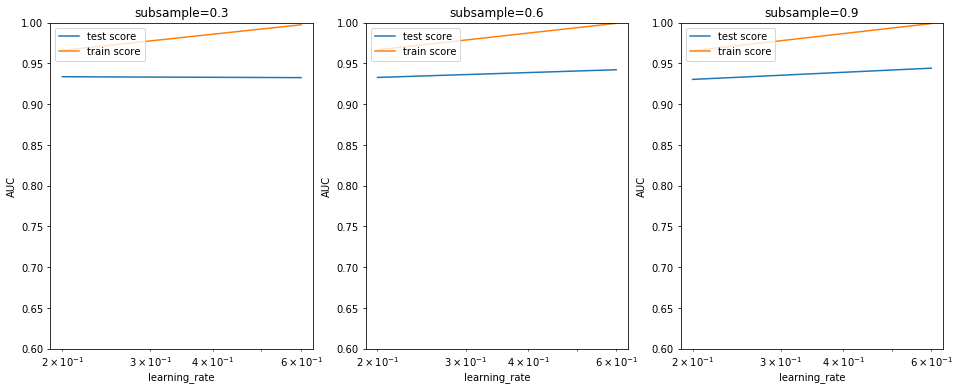

In [31]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"])
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('AUC')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [32]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.6,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(train_pca, y_train)

[23:48:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { params } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob',
              params={'learning_rate': 0.6, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [41]:
# predict
y_pred = model.predict(test_pca)
y_pred[:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

In [34]:
# metrics
train_score = model.score(train_pca, y_train)

In [35]:
train_score

1.0

In [42]:
# Saving predictions to a .csv file
# the testing accuracy (in terms of how many correct classifications)

ImageId = [i+1 for i in range(len(y_pred))]
kaggle = pd.DataFrame({'ImageId':ImageId,'Label':(y_pred)})
filename = 'Digit Recognizer - XGB.csv'
kaggle.to_csv(filename,index=False)
print('Saved file: ' + filename)
kaggle.head()

Saved file: Digit Recognizer - XGB.csv


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [50]:
from catboost import CatBoostClassifier
cb_model = CatBoostClassifier(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             loss_function='MultiClass',
                             od_wait=20)

In [51]:
cb_model.fit(train_pca, y_train)

0:	total: 7.42s	remaining: 1h 1m 42s
50:	total: 4m 2s	remaining: 35m 34s
100:	total: 7m 49s	remaining: 30m 56s
150:	total: 11m 42s	remaining: 27m 2s
200:	total: 15m 52s	remaining: 23m 36s
250:	total: 19m 27s	remaining: 19m 18s
300:	total: 23m 8s	remaining: 15m 18s
350:	total: 26m 58s	remaining: 11m 27s
400:	total: 30m 46s	remaining: 7m 35s
450:	total: 34m 27s	remaining: 3m 44s
499:	total: 38m 1s	remaining: 0us


In [52]:
y_pred = cb_model.predict(test_pca)
y_pred[:10]

array([[2],
       [0],
       [9],
       [9],
       [3],
       [7],
       [0],
       [3],
       [0],
       [3]])

In [53]:
# metrics
train_score = cb_model.score(train_pca, y_train)
train_score

0.9948095238095238

In [54]:
# Saving predictions to a .csv file
# the testing accuracy (in terms of how many correct classifications)

ImageId = [i+1 for i in range(len(y_pred))]
kaggle = pd.DataFrame({'ImageId':ImageId,'Label':(y_pred)})
filename = 'Digit Recognizer - CB.csv'
kaggle.to_csv(filename,index=False)
print('Saved file: ' + filename)
kaggle.head()

Exception: Data must be 1-dimensional